In [ ]:
# default_exp plotting

In [ ]:
#export
import matplotlib.pyplot as plt
from matplotlib import gridspec
import numpy as np

In [ ]:
#export
def plot_2d_sta(sta):
    sta = np.array(sta)
    if len(sta.shape) == 2:
        sta = [sta]
    fig = plt.figure(figsize=(20,10))
    gs = gridspec.GridSpec(len(sta)//8 + 1, 8)    
    for i, frame in enumerate(sta):
        ax1 = plt.subplot(gs[i//8, i%8])
        ax1.imshow(frame, cmap='gray',vmin=-1, vmax=1)

In [ ]:
from theonerig.core import *
from theonerig.processing import *
from theonerig.utils import *
from os.path import join
import matplotlib.pyplot as plt
vivo_2p_dir = "./files/vivo_2p"
reM = import_record(join(vivo_2p_dir, "record_master.h5"))
pipe = Data_Pipe(reM, ["checkerboard", "eye_tracking", "S_matrix"], ["stim_inten", "eye_track", "spike_counts"])
pipe += "checkerboard"
result_sta = process_sta_batch(eyetrack_stim_inten(pipe[0]["stim_inten"], pipe[0]["eye_track"]), 
                               pipe[0]["spike_counts"], Hw=40)

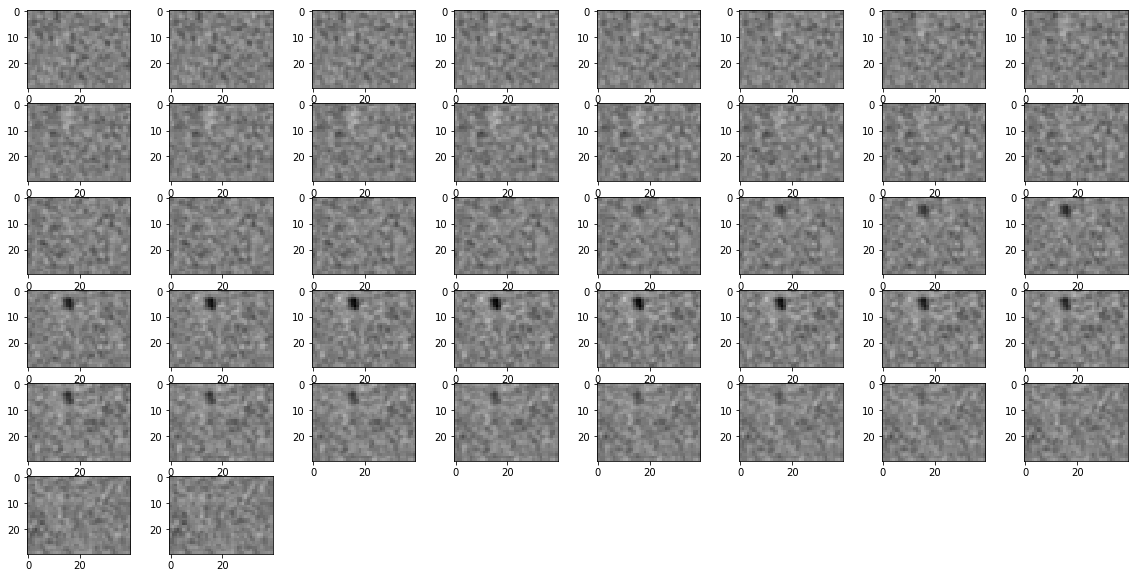

In [ ]:
plot_2d_sta(result_sta[0])

In [ ]:
from nbdev.export import *
notebook2script()

Converted 00_core.ipynb.
Converted 01_utils.ipynb.
Converted 02_processing.ipynb.
Converted 03_modelling.ipynb.
Converted 04_plotting.ipynb.
Converted index.ipynb.
